<a href="https://colab.research.google.com/github/zhpinkman/neural-network/blob/master/article-classification-naive-bayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm

In [ ]:
# Install PyDrive
!pip install PyDrive

#Import modules
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

#Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
downloaded = drive.CreateFile({'id':"16Z56KEdMZ07wlLeVWfeWPf7Evgco1yOd"})  # Train
downloaded.GetContentFile('books_train.csv')       

downloaded = drive.CreateFile({'id':"1RN6Xaa3zRCWUpYuKdkiPE16gj4XCybWh"})  # Test
downloaded.GetContentFile('books_test.csv')       

train_df = pd.read_csv('books_train.csv')
test_df = pd.read_csv('books_test.csv')

In [ ]:
print(train_df.shape)
print(test_df.shape)
train_df.head()

(2550, 3)
(450, 3)


,title,description,categories
0,ساختار نظریه‌های جامعه‌شناسی ایران,«ساختار نظریه‌های جامعه‌شناسی ایران» نوشته ابو...,جامعه‌شناسی
1,جامعه و فرهنگ کانادا,«جامعه و فرهنگ کانادا» از مجموعه کتاب‌های «جام...,جامعه‌شناسی
2,پرسش از موعود,پرسش‌های مختلفی درباره زندگی و شخصیت امام مهدی...,کلیات اسلام
3,موج، دریا,«موج دریا» به قلم مهری ماهوتی (-۱۳۴۰) و تصویرگ...,داستان کودک و نوجوانان
4,پرسش از غرب,«پرسش از غرب» به قلم دکتر اسماعیل شفیعی سروستا...,جامعه‌شناسی


In [ ]:
print(train_df['categories'].value_counts())
print(test_df['categories'].value_counts())

داستان کوتاه              425
داستان کودک و نوجوانان    425
مدیریت و کسب و کار        425
کلیات اسلام               425
جامعه‌شناسی               425
رمان                      425
Name: categories, dtype: int64
داستان کوتاه              75
رمان                      75
داستان کودک و نوجوانان    75
کلیات اسلام               75
جامعه‌شناسی               75
مدیریت و کسب و کار        75
Name: categories, dtype: int64


In [ ]:
!npx degit mhbashari/awesome-persian-nlp-ir/ -f
def remove_bad_chars(df):
    bad_chars = ['\n', '\r', '\.']
    # bad_chars.extend(["کتاب", "مجموعه"])
    for bad_char in bad_chars:
        df = df.str.replace(bad_char, ' ')
    df = df.str.replace('[^\w\s]', ' ')  # Remove all punctuations (nim fasele ham)

    with open("stopwords.txt") as stopwords_file:
        for stopword in tqdm(stopwords_file):
            # print(stopword.strip(), end=", ")
            # print(df[0])
            df = df.str.replace(' ' + stopword.strip() + ' ', ' ', regex=False)
    df = df.replace('\s+', ' ', regex=True)
    return df

npx: installed 1 in 3.15s
> destination directory is not empty. Using --force, continuing
> cloned mhbashari/awesome-persian-nlp-ir#HEAD


In [ ]:
clean_train_df = train_df.copy()
clean_train_df['title'] = remove_bad_chars(clean_train_df['title'])
clean_train_df['description'] = remove_bad_chars(clean_train_df['description'])
clean_train_df['categories'] = remove_bad_chars(clean_train_df['categories'])
clean_test_df = test_df.copy()
clean_test_df['title'] = remove_bad_chars(clean_test_df['title'])
clean_test_df['description'] = remove_bad_chars(clean_test_df['description'])
clean_test_df['categories'] = remove_bad_chars(clean_test_df['categories'])

clean_train_df['description'] = clean_train_df['title'] + " " + clean_train_df['description']
clean_test_df['description'] = clean_test_df['title'] + " " + clean_test_df['description']

# delete_cats = ["جامعه شناسی", "کلیات اسلام", "رمان", "داستان کوتاه"]
# for c in delete_cats:
#     clean_train_df = clean_train_df[clean_train_df['categories'] != c]
#     clean_test_df = clean_test_df[clean_test_df['categories'] != c]

clean_train_df.index = np.arange(1, len(clean_train_df) + 1)
clean_test_df.index = np.arange(1, len(clean_test_df) + 1)
clean_train_df

1263it [00:02, 555.08it/s]
1263it [00:08, 151.26it/s]
1263it [00:01, 651.59it/s]
1263it [00:00, 1503.55it/s]
1263it [00:01, 680.45it/s]
1263it [00:00, 1705.17it/s]


,title,description,categories
1,ساختار نظریه جامعه ایران,ساختار نظریه جامعه ایران ساختار نظریه جامعه ا...,جامعه شناسی
2,جامعه فرهنگ کانادا,جامعه فرهنگ کانادا جامعه فرهنگ کانادا مجموعه ...,جامعه شناسی
3,پرسش موعود,پرسش موعود پرسش مختلفی زندگی شخصیت امام مهدی ع...,کلیات اسلام
4,موج دریا,موج دریا موج دریا قلم مهری ماهوتی ۱۳۴۰ تصویرگ...,داستان کودک نوجوانان
5,پرسش غرب,پرسش غرب پرسش غرب قلم دکتر اسماعیل شفیعی سروس...,جامعه شناسی
...,...,...,...
2546,قضاوت امیرمؤمنان حضرت علی السلام,قضاوت امیرمؤمنان حضرت علی السلام آنچه قضاوت ام...,کلیات اسلام
2547,کراماتی مهدی موعود عج,کراماتی مهدی موعود عج زینب محمودی پژوهشگر دین...,کلیات اسلام
2548,انتقام انتقام انتقام,انتقام انتقام انتقام انتقام انتقام انتقام داس...,داستان کوتاه
2549,آن مرد آید,آن مرد آید مرد قلم سیده فاطمه موسوی تصویرگری ...,داستان کودک نوجوانان


In [ ]:
import operator
from tqdm import tqdm

class Bayes_classifier:
    def __init__(self, mode):
        self.target_classes = []
        self.token_to_count = None  # token_to_count[class][token]
        self.total_tokens_count = dict()
        self.vocab_size = None
        self.mode = mode
    # Private
    def count_tokens(self, df, input_col, target_col):
        token_to_count = dict()
        for row_index in df.index:
            target_class = df[target_col][row_index]
            if target_class not in token_to_count:
                token_to_count[target_class] = dict()
            for token in df[input_col][row_index].split():
                if token not in token_to_count[target_class]:
                    token_to_count[target_class][token] = 1
                else:
                    token_to_count[target_class][token] += 1
        return token_to_count

    def count_tokens_bigram(self, df, input_col, target_col):
        token_to_count = dict()
        for row_index in df.index:
            target_class = df[target_col][row_index]
            if target_class not in token_to_count:
                token_to_count[target_class] = dict()
            tokens = df[input_col][row_index].split()
            for token_index in range(len(tokens) - 1):
                if (tokens[token_index],tokens[token_index + 1]) not in token_to_count[target_class]:
                    token_to_count[target_class][(tokens[token_index],tokens[token_index + 1])] = 1
                else:
                    token_to_count[target_class][(tokens[token_index],tokens[token_index + 1])] += 1
        return token_to_count
    
    # Private
    def count_classes_total_tokens(self):
        vocab_set = set()
        for target_class in self.target_classes:
            self.total_tokens_count[target_class] = sum(list(self.token_to_count[target_class].values()))
            vocab_set.update(list(self.token_to_count[target_class].keys()))
        self.vocab_size = len(vocab_set)
        print("Vocab Size:", self.vocab_size)

    # Private
    def calculate_token_score(self, token, target_class, method="none"):
        if method == "additive smoothing":
            return (self.token_to_count[target_class].get(token, 0) + 1) / (self.total_tokens_count[target_class] + self.vocab_size + 1)
        else:
            return self.token_to_count[target_class].get(token, 0) / self.total_tokens_count[target_class]

    # Public
    def train(self, train_df, input_col, target_col):
        if self.mode == 'unigram':
            self.token_to_count = self.count_tokens(train_df, input_col, target_col)
        else: 
            self.token_to_count = self.count_tokens_bigram(train_df, input_col, target_col)
        self.target_classes = list(self.token_to_count.keys())
        self.count_classes_total_tokens()
        print("Total Tokens in Each Class:\n", self.total_tokens_count)

    # Public
    def predict_one_unigram(self, test_input, method="none"):
        class_scores = dict()
        for target_class in self.target_classes:
            # print(target_class)
            class_scores[target_class] = 1
            for token in test_input.split():
                # print(token, self.token_to_count[target_class].get(token, 0.5) / self.total_tokens_count[target_class])
                class_scores[target_class] += np.log(self.calculate_token_score(token, target_class, method))
            # class_scores[target_class] *= self.total_tokens_count[target_class] / sum(list(self.total_tokens_count.values()))
        return class_scores
    def predict_one_bigram(self, test_input, method="none"):
        class_scores = dict()
        for target_class in self.target_classes:
            # print(target_class)
            class_scores[target_class] = 1
            tokens = test_input.split()
            for token_index in range(len(tokens) - 1):
                # print(token, self.token_to_count[target_class].get(token, 0.5) / self.total_tokens_count[target_class])
                class_scores[target_class] += np.log(self.calculate_token_score((tokens[token_index],tokens[token_index + 1]), target_class, method))
            # class_scores[target_class] *= self.total_tokens_count[target_class] / sum(list(self.total_tokens_count.values()))
        return class_scores
    
    # Public
    def predict_all(self, test_df, input_col, method="none"):
        df = test_df
        results = []
        for row_index in tqdm(df.index):
            if self.mode == 'unigram':
                scores = self.predict_one_unigram(df[input_col][row_index], method)
            else:
                scores = self.predict_one_bigram(df[input_col][row_index], method)
            max_class = max(scores.items(), key=operator.itemgetter(1))[0]
            results.append(max_class)
        return results
    def predict_one(self, test_input, method='none'):
        if self.mode == 'unigram':
            return self.predict_one_unigram(test_input, method)
        else:
            return self.predict_one_bigram(test_input, method)
    
    def get_classes(self):
        return self.target_classes

    def get_best_tokens(self, n=5):
        best_tokens = dict()
        for c in self.target_classes:
            best_tokens[c] = dict(sorted(self.token_to_count[c].items(), key=operator.itemgetter(1), reverse=True)[:n])
        return best_tokens


Vocab Size: 28232
Total Tokens in Each Class:
 {'جامعه شناسی': 49666, 'کلیات اسلام': 36857, 'داستان کودک نوجوانان': 22010, 'داستان کوتاه': 45348, 'مدیریت کسب کار': 39803, 'رمان': 58805}


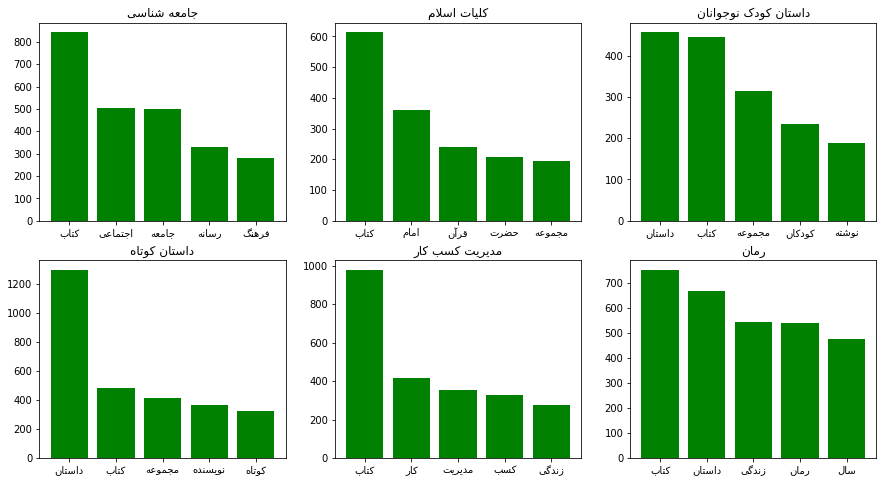

In [ ]:
!pip install arabic-reshaper
!pip install python-bidi
import matplotlib.pyplot as plt
from bidi.algorithm import get_display
from arabic_reshaper import reshape

mode = 'unigram'

bayes_classifier = Bayes_classifier(mode)
bayes_classifier.train(clean_train_df, 'description', 'categories')
best_tokens = bayes_classifier.get_best_tokens()

plt.figure(figsize=(15, 8))
for i, c in enumerate(best_tokens):
    plt.subplot(2, 3, i+1)
    plt.gca().set_title(get_display(reshape(c)))
    if mode == 'unigram':
        plt.bar([get_display(reshape(label)) for label in best_tokens[c].keys()], best_tokens[c].values(), color='g')
    else:
        plt.bar([get_display(reshape(' '.join(label))) for label in best_tokens[c].keys()], best_tokens[c].values(), color='g')
plt.show()

In [ ]:
bayes_classifier.predict_one("نوجوانان")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: RuntimeWarning: divide by zero encountered in log


{'جامعه شناسی': -7.510490780356562,
 'داستان کوتاه': -8.62350906446938,
 'داستان کودک نوجوانان': -4.317120947396288,
 'رمان': -7.342924834669878,
 'مدیریت کسب کار': -inf,
 'کلیات اسلام': -7.435359297192102}

In [ ]:
results = bayes_classifier.predict_all(clean_test_df, 'description', method='additive smoothing')
# results = bayes_classifier.predict_all(clean_test_df, 'description', method='none')

100%|██████████| 450/450 [00:00<00:00, 673.07it/s]


In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
def evaluate(predictions, reference):
    true = dict()
    false = dict()
    total_true = 0
    total_false = 0
    for c in bayes_classifier.get_classes():
        true[c] = 0
        false[c] = 0

    for i in range(len(predictions)):
        if predictions[i] == reference[i]:
            total_true += 1
            true[predictions[i]] += 1
        else:
            total_false += 1
            false[predictions[i]] += 1
    print("#Total_true:", total_true, "#Total_false:", total_false)
    print("CLASS ERRORS:\n", false)
    print(classification_report(reference, predictions))
    return f1_score(reference, predictions, average=None, labels=bayes_classifier.get_classes())

In [ ]:
print("#Total tests:", len(results))
print(evaluate(results, clean_test_df["categories"].to_list()))
print(results[5:6])
print(clean_test_df["categories"].to_list()[5:6])

#Total tests: 450
#Total_true: 373 #Total_false: 77
CLASS ERRORS:
 {'جامعه شناسی': 18, 'کلیات اسلام': 8, 'داستان کودک نوجوانان': 3, 'داستان کوتاه': 17, 'مدیریت کسب کار': 5, 'رمان': 26}
                      precision    recall  f1-score   support

         جامعه شناسی       0.79      0.89      0.84        75
        داستان کوتاه       0.76      0.72      0.74        75
داستان کودک نوجوانان       0.95      0.75      0.84        75
                رمان       0.71      0.85      0.78        75
      مدیریت کسب کار       0.93      0.93      0.93        75
         کلیات اسلام       0.89      0.83      0.86        75

            accuracy                           0.83       450
           macro avg       0.84      0.83      0.83       450
        weighted avg       0.84      0.83      0.83       450

[0.8375     0.85517241 0.8358209  0.73972603 0.93333333 0.77575758]
['جامعه شناسی']
['کلیات اسلام']


In [ ]:
num_errors_to_print = 5
error_counter = 0
i = 0
while error_counter < num_errors_to_print:
    if results[i] != clean_test_df["categories"].to_list()[i]:
        print(i, "LABEL:", clean_test_df["categories"].to_list()[i], "PRED:", results[i], "\nTEXT:", clean_test_df["description"].to_list()[i])
        print("-----------")
        error_counter += 1
    i += 1

0 LABEL: داستان کوتاه PRED: رمان 
TEXT: کآشوب  کآشوب سه روایت روضه زندگی همت نفیسه مرشدزاده جمع آوری کآشوب روایت نسبت نسل متفاوت واقعه سال ۶۱ هجری شهادت مظلومانه امام حسین السلام نویسندگان شغل گرایش قرار لحن توصیفی نسبت شخصی زیسته مجالس گزارش دل دست و شیفتگی متن زده مجموعه ذره مداوم اثری حوزه عاشورا محرم تولید محض تولد هزارانی دوره ساحت واقعه نشدنی پیشکش روایت هفتم فراز تپه علی غبیشاوی شانزده هفده ساله سه ماه تابستان تعطیلات سال نو قم کاری رفتیم خوزستان روستای پدری حاج بابا اولین محرم افتاده تعطیلات اولین محرم قم نبودیم اتصالی سیم باندهای حیاط وصله زدم میخ درآمده پایه عقبی منبر چکش جایش برمی گرداندم نردبان تار عنکبوت گوشه حسینیه ماه قم روبه نامانوس عزاداری عربی عادت دلهره دلهره شروع دهه محرم سه عاشورا برگشتم قم زندگی طولانی دور خوزستان و حضورم جمع عرب زبان شهر منحصر صحبت عربی خانواده وگوی روزمره دایره لغات عربی محدود ساختار زبان پیچیده نیمچه فاخر سخنران حسینیه حاج بابا آوردم معنای کلمات ترجیع بندها ابوذیه مصیبت خوانی حاضران حسینیه دست پهنای گریبان اشک ریختند ناله توریستی شهری غریب وسط 

## --------------------------------------------DONE-------------------------